# Constructing a subset from weighted samples

The algorithm can easily be adapted to select a subset from a weighted set of points.

In this example we look at a set of points which are drawn from a univariate Gaussian, but with associated weights such that the weighted distribution corresponds to a mixture of two Gaussians.

Running the subset selection algorithm chooses a small *unweighted* set of points, approximating the distribution of the weighted points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats

sys.path.insert(0, '../src')

import subsample, herding, rptree, rff
%matplotlib inline

In [2]:
np.random.seed(1)

N = int(1e5)+1

def proposal():
    return np.random.randn()*3

normpdf = stats.norm(0,1).pdf

def set_weight(x):
    value = np.log(0.3*normpdf((x+0.5)/2) + 0.7*normpdf((x-3.5)/0.5))
    proposal = np.log(normpdf((x/3.0)))
    return value - proposal

stream = np.array([[proposal()] for a in xrange(N)])
stream_weights = np.array([set_weight(x) for x in stream]).ravel()

## Plot the data

The blue line shows a histogram of all the points in the stream of data.

Each point also has an associated weight, which we interperet as an unnormalized log probability. The corresponding distribution of *weighted* samples is shown in the beige histogram.

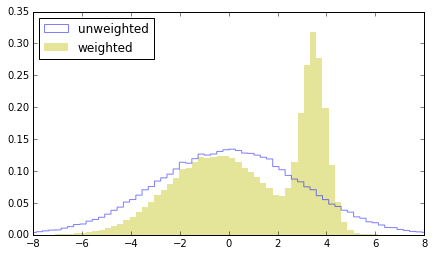

In [3]:
plt.figure(figsize=(7,4))
plt.hist(stream, weights=np.exp(stream_weights), bins=100, normed=True, alpha=0.4, color='y', linewidth=0.0)
plt.xlim([-8,8])
plt.hist(stream, normed=True, alpha=0.5, color='b', histtype='step', bins=100);
plt.legend(['unweighted', 'weighted'], loc='best');

## Selecting a subset

Here we explore what happens if we choose to select 2, 3, 5, or 8 total points to approximate the weighted distribution.

In the plot (at the bottom of the notebook), we show on the vertical axis how this converges in each case, when more of the points from the weighted stream of data are considered.

In [4]:
D = 200
dim = stream[0].shape[0]


def systematic_resample(log_weights):
    A = log_weights.max()
    normalizer = np.log(np.exp(log_weights - A).sum()) + A
    weights = np.exp(log_weights - normalizer)
    ns = len(weights)
    cdf = np.cumsum(weights)
    cutoff = (np.random.rand() + np.arange(ns))/ns
    return np.digitize(cutoff, cdf)

resampled_stream = stream[systematic_resample(stream_weights[:50])]
lengthscale = rff.median_heuristic(resampled_stream[:50])/2
phi = rff.RFF(D, dim, lengthscale)

In [5]:
snapshots = {2: [], 3: [], 5: [], 8: []}
for M in snapshots.keys():
    
    print "\n\nM =",M
    initial_points = stream[:M]
    subsampler = subsample.TreeSubsampler(initial_points, phi)
    for i in xrange(M, len(stream)):
        subsampler.consider(stream[i], log_weight=stream_weights[i])
        if np.log10(i) == int(np.log10(i)): # or np.log10(i*2) == int(np.log10(i*2)):
            print "snapshot:", i
            snapshots[M].append((i, np.array(subsampler.points.ravel())))




M = 8
Size of subsample: 8
Number of items: 8
Each item dimension: 200
Tree depth: 1
Expected number of points at leaf: 4.0
snapshot: 10
snapshot: 100
snapshot: 1000
snapshot: 10000
snapshot: 100000


M = 2
Size of subsample: 2
Number of items: 2
Each item dimension: 200
Tree depth: 0
Expected number of points at leaf: 2.0
snapshot: 10
snapshot: 100
snapshot: 1000
snapshot: 10000
snapshot: 100000


M = 3
Size of subsample: 3
Number of items: 3
Each item dimension: 200
Tree depth: 0
Expected number of points at leaf: 3.0
snapshot: 10
snapshot: 100
snapshot: 1000
snapshot: 10000
snapshot: 100000


M = 5
Size of subsample: 5
Number of items: 5
Each item dimension: 200
Tree depth: 1
Expected number of points at leaf: 2.5
snapshot: 10
snapshot: 100
snapshot: 1000
snapshot: 10000
snapshot: 100000


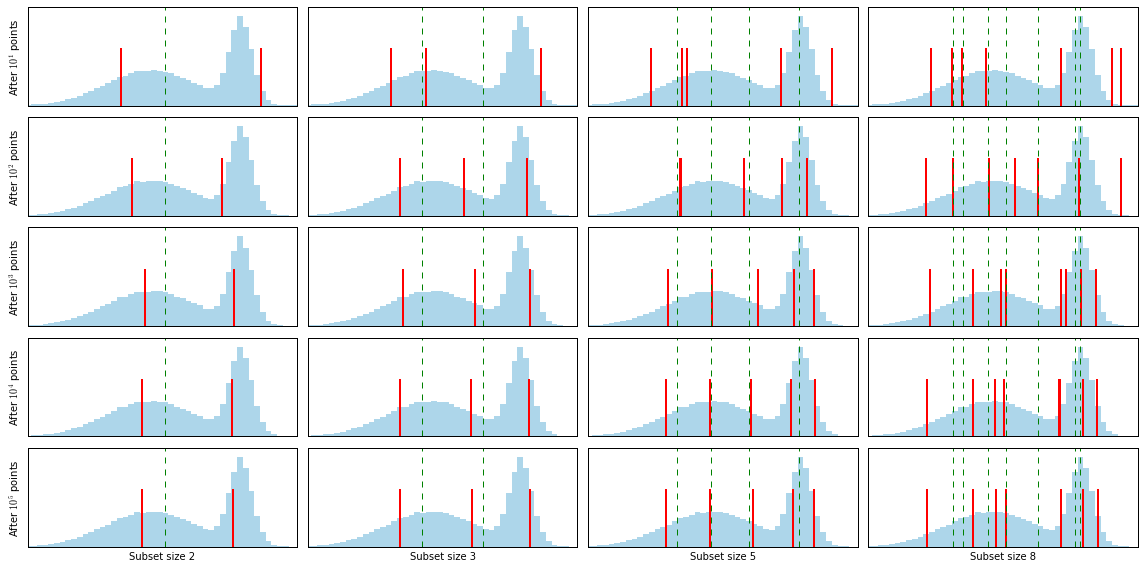

In [6]:
num_checkpoints = len(snapshots[M])

plt.figure(figsize=(16,8))
for j, M in enumerate(sorted(snapshots.keys())):
#     print "processing",j,"M=",M
    splits = np.linspace(100./(M),100-100.0/(M), M-1)
    percentiles = np.percentile(resampled_stream, splits)
#     print "splits:", splits.round(0)
    for i, data in enumerate(snapshots[M]):
        ns, points = data
        assert len(snapshots[M]) == num_checkpoints
        gridpoint = i*len(snapshots)+j+1
        plt.subplot(num_checkpoints,len(snapshots), gridpoint)
#         print "plotting at location", gridpoint,"ns=",ns
        plt.hist(stream, weights=np.exp(stream_weights), bins=100, normed=True, linewidth=0.0, alpha=0.4, color='#3399cc', label='data');
        plt.plot(np.vstack((points, points)), 0.2*np.vstack((np.zeros(len(percentiles)), np.ones(len(percentiles)))), 'r-', linewidth=2.0);
        ylm = plt.ylim()
        xlm = plt.xlim(-6,6)
        plt.plot(np.vstack((percentiles, percentiles)), 1*np.vstack((np.zeros(len(percentiles)), np.ones(len(percentiles)))), 'g--', linewidth=1.0);
        plt.xlim(xlm)
        plt.ylim(ylm)
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            plt.ylabel("After $10^%d$ points" % int(np.log10(ns)))
        if i == num_checkpoints-1:
            plt.xlabel("Subset size %d" % M)
    
plt.tight_layout();